In [18]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datetime import datetime

import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss_pixel
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE, AUTO_VAE
from core.fisher_utils_VAE import Calculate_fisher_VAE_ekfac, Calculate_score_VAE_ekfac
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=opt.train_dist, num=1, ngf=64, nz=200, beta=1, augment='hflip', epoch=100)
netE.eval()
netG.eval()
modules = [] # Write the name of modules you want to see

In [3]:
#results = {}
start = datetime.now()
sampling = 10000
for i in [8, 9]:
    auroc = {}
    SCOREs = {}

    U_A, U_B, S, mean, std = Calculate_fisher_VAE_ekfac(netE, netG, opt, select_modules=modules, max_iter=sampling, seed=2021+i+sampling)

    for ood in [opt.train_dist, 'overall']:
        score = Calculate_score_VAE_ekfac(netE, netG, opt, U_A, U_B, S, ood, max_iter=5000, seed=2021+i+sampling)
        temp = []
        for name in score.keys():
            a = np.array(score[name])
            a = (a - mean[name]) / std[name]  
            temp.append(a) 
        score = np.max(np.concatenate(temp, 1), 1)
        SCOREs[ood] = score
        args = [SCOREs[opt.train_dist], SCOREs[ood]]
        labels = [opt.train_dist, ood]
        auroc[ood] = AUROC(*args, labels=labels, verbose=False)
        print(f'{opt.train_dist}/{ood} {auroc[ood]}')

        if ood == 'overall':
            np.save(f'./temp/{opt.train_dist}_sampling_{sampling}_{i}.npy', np.array([auroc[ood]]))




Files already downloaded and verified


Calculate A, B:   0%|                                                                      | 0/50000 [00:00<?, ?step/s]

(0): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
(1): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
(2): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate A, B:  20%|███████████▌                                              | 9999/50000 [01:04<04:16, 155.75step/s]


Files already downloaded and verified


Calculate Fisher Inverse:  20%|█████████▌                                      | 9999/50000 [01:11<04:45, 140.29step/s]


Files already downloaded and verified


Calculate Score of cifar10(train):  20%|███████▊                               | 9999/50000 [01:28<05:54, 112.94step/s]


Files already downloaded and verified


Calculate Score of overall:   0%|                                                          | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of overall:   0%|                                                | 11/10000 [00:00<01:36, 104.05step/s]

Average Inference Time : 0.008934626 seconds
Average #Images Processed : 111.92410292271887 Images
cifar10/cifar10 0.5


Calculate Score of overall:  50%|██████████████████████▉                       | 4999/10000 [00:45<00:45, 108.77step/s]


cifar10/overall 0.91656596
Files already downloaded and verified


Calculate A, B:   0%|                                                                      | 0/50000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate A, B:   0%|                                                            | 12/50000 [00:00<07:05, 117.37step/s]

(0): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
(1): Conv2d(256, 200, kernel_size=(4, 4), stride=(1, 1))
(2): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
(4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


Calculate A, B:  20%|███████████▌                                              | 9999/50000 [01:21<05:24, 123.19step/s]


Files already downloaded and verified


Calculate Fisher Inverse:  20%|█████████▌                                      | 9999/50000 [01:31<06:05, 109.39step/s]


Files already downloaded and verified


Calculate Score of cifar10(train):  20%|███████▉                                | 9999/50000 [01:47<07:09, 93.08step/s]


Files already downloaded and verified


Calculate Score of overall:   0%|                                                          | 0/10000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score of overall:   0%|                                                 | 10/10000 [00:00<01:49, 91.15step/s]

Average Inference Time : 0.0106880556 seconds
Average #Images Processed : 93.562387530993 Images
cifar10/cifar10 0.5


Calculate Score of overall:  50%|███████████████████████▍                       | 4999/10000 [00:54<00:54, 90.98step/s]

cifar10/overall 0.9180019399999999


In [123]:
dist = 'fmnist'
s = 10000
df.loc[df['Sampling'] == s].loc[df['In-dist'] == dist].iloc[:, 0].describe()

count    10.000000
mean      0.998432
std       0.000307
min       0.997790
25%       0.998361
50%       0.998393
75%       0.998622
max       0.998942
Name: auroc, dtype: float64

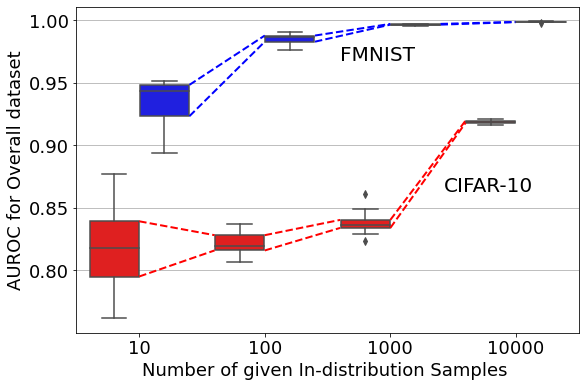

In [142]:
df = {'auroc': [], 'In-dist': [], 'Sampling': []}
for dist in ['cifar10', 'fmnist']:
    for sampling in [10, 100, 1000, 10000]:
        path = f'./temp/{dist}_sampling_{sampling}.npy'
        array = np.load(path)
        for i in range(len(array)):
            df['auroc'].append(array[i])
            df['In-dist'].append(dist)
            df['Sampling'].append(sampling)
df = pd.DataFrame(df)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
#ax.axvline(x=0.5, color='purple', linestyle='dashdot')
#ax.axvline(x=1.5, color='purple', linestyle='dashdot')
#ax.axvline(x=2.5, color='purple', linestyle='dashdot')
# CIFAR10
ax.plot([0.0, 0.6], [0.7952, 0.8160], c='r', linestyle='--', linewidth=2)
ax.plot([0.0, 0.6], [0.8393, 0.8282], c='r', linestyle='--', linewidth=2)
ax.plot([1.0, 1.6], [0.8160, 0.8340], c='r', linestyle='--', linewidth=2)
ax.plot([1.0, 1.6], [0.8282, 0.8404], c='r', linestyle='--', linewidth=2)
ax.plot([2.0, 2.6], [0.8340, 0.9180], c='r', linestyle='--', linewidth=2)
ax.plot([2.0, 2.6], [0.8404, 0.9198], c='r', linestyle='--', linewidth=2)
textstr = 'CIFAR-10'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
ax.text(0.82, 0.48, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, ha='center')
# FMNIST
ax.plot([0.4, 1.0], [0.9233, 0.9828], c='b', linestyle='--', linewidth=2)
ax.plot([0.4, 1.0], [0.9483, 0.9877], c='b', linestyle='--', linewidth=2)
ax.plot([1.4, 2.0], [0.9828, 0.9964], c='b', linestyle='--', linewidth=2)
ax.plot([1.4, 2.0], [0.9877, 0.9970], c='b', linestyle='--', linewidth=2)
ax.plot([2.4, 3.0], [0.9964, 0.9984], c='b', linestyle='--', linewidth=2)
ax.plot([2.4, 3.0], [0.9970, 0.9986], c='b', linestyle='--', linewidth=2)
textstr = 'FMNIST'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
ax.text(0.6, 0.88, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, ha='center')

ax.grid()
ax.set_axisbelow(True)


mypal = {'cifar10': 'r', 'fmnist': 'b'}
ax = sns.boxplot(x='Sampling', y='auroc', hue='In-dist', data=df, palette=mypal)

ax.set_xlabel('Number of given In-distribution Samples ', fontsize=18)
ax.set_ylabel('AUROC for Overall dataset', fontsize=18)
plt.legend([],[], frameon=False)
plt.show()
fig.savefig(f'./images/robust_sampling/robust_sampling.png', dpi=400)